In [1]:
import pbjam as pb
from pbjam.jar import session
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk 
import sys

In [2]:
kic = '4448777'
numax = [220.0, 3.0]
dnu = [16.97, 0.01]
teff = [4750, 100]
bp_rp = [1.34, 0.01]

In [3]:
# Initialize a jam session with a single star:
jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], bp_rp = [bp_rp], nthreads=4)

# with more than one star:
#jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], bp_rp = [bp_rp,bp_rp], teff = [teff,teff])

# # with own timeseries:
# time,flux = np.genfromtxt('Examples/mypsd.asciifile').T
# jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], 
#                    teff = [teff], bp_rp = [bp_rp], timeseries = [(time,flux)])

# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], timeseries = [(time,flux),(time,flux)])

# # in ascii format
# jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], timeseries = ['Examples/myts.asciifile'])
# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], timeseries = ['Examples/myts.asciifile','Examples/myts.asciifile'])

# # in lightkurve format
# lc = lk.search_lightcurvefile(target=kic, quarter=5, cadence = 'long').download().PDCSAP_FLUX
# lc = lc.remove_nans().remove_outliers().flatten().normalize()
# jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], timeseries = [lc])
# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], timeseries = [lc,lc])


# # with own powerspectrum:
# freq, power = np.genfromtxt('Examples/mypsd.asciifile').T
# jam_sess = session(ID = [kic], numax = [numax],dnu = [dnu], teff = [teff], psd = [(freq, power)])
# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], psd = [(freq, power),(freq, power)])

# # in ascii format:
# jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], psd = ['Examples/mypsd.asciifile'])
# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], psd = ['Examples/mypsd.asciifile','Examples/mypsd.asciifile'])

# # in lightkurve format
# time, flux = np.array(lc.time), np.array(lc.flux)
# pg = lk.LightCurve(time, flux).to_periodogram(normalization='psd').flatten()
# jam_sess = session(ID = [kic], numax = [numax], dnu = [dnu], teff = [teff], psd = [pg])
# jam_sess = session(ID = [kic,kic], numax = [numax,numax], dnu = [dnu,dnu], 
#                    teff = [teff,teff], bp_rp = [bp_rp,bp_rp], psd = [pg,pg])

In [4]:
# Result is always a list of star class instances
# Taking the first one as an example
star = jam_sess.stars[0]

In [5]:
# Do mode ID for one of the stars using the asymptotic method on 7 radial orders
star.asymptotic_modeid(norders = 7)

Burningham
Sampling


In [6]:
# Result is a dataframe
print(star.asy_modeID)

    ell       nu_mu    nu_std
0     2  157.475898  0.071047
1     0  159.671037  0.065576
2     2  174.090759  0.041499
3     0  176.285584  0.035395
4     2  190.820574  0.025453
5     0  193.015590  0.019396
6     2  207.665906  0.021602
7     0  209.860971  0.017677
8     2  224.628422  0.021372
9     0  226.823386  0.018431
10    2  241.706460  0.023073
11    0  243.902372  0.019290
12    2  258.900985  0.035268
13    0  261.096408  0.030985


ValueError: err must be a scalar or a 1D or (2, n) array-like

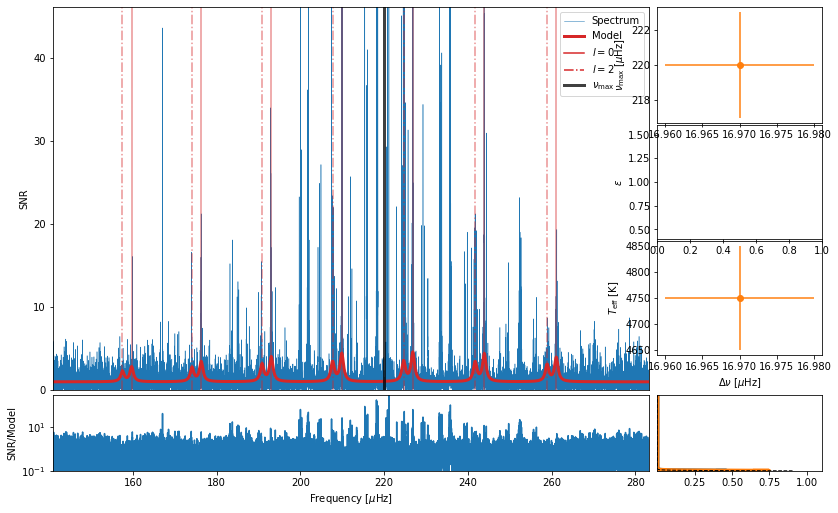

In [7]:
fig = star.plot_asyfit()